# (08) DOVES—Pois—Lin—0

**Motivation**: New defaults fit **[best one is kept in this notebook]**. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Build model + trainer

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'lin|lin')
print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'DOVES', 'n_ch': 32, 'n_latents': 512, 'prior_clamp': -4, 'fit_prior': True, 'enc_type': 'lin', 
'dec_type': 'lin', 'enc_bias': False, 'dec_bias': False, 'init_dist': 'Normal', 'init_scale': 0.05}

Trainer:
{'lr': 0.005, 'batch_size': 1000, 'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 
'kl_const_portion': 0.0}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_DOVES_z-512_fp_<lin|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_05_08,19:25)

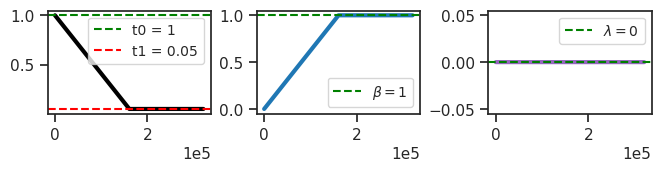

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [5]:
print(vae)

PoissonVAE(
  (mse): MSELoss()
  (fc_enc): Linear(in_features=256, out_features=512, bias=False)
  (fc_dec): Linear(in_features=512, out_features=256, bias=False)
)

In [6]:
vae.fc_dec.bias, vae.fc_enc.bias #.shape

(None, None)

In [7]:
vae.cfg.rmax_q, tr.cfg.kl_const_portion

(1.0, 0.0)

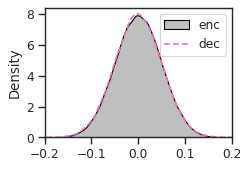

In [8]:
fig, ax= create_figure(dpi=80)
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.2, 0.2))
add_legend(ax)
plt.show()

### Train

In [9]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3000, avg loss: 167.718641: 100%|███████████████████████| 3000/3000 [56:21<00:00,  1.13s/it]


### Loss vld (freeze)

In [49]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 137.58003, 'kl': 29.510105, 'kl_diag': 0.056955107, 'tot': 167.09013}

### Identify dead neurons

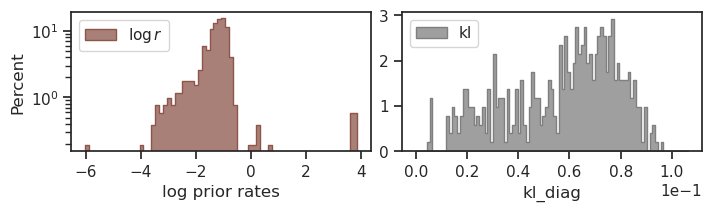

In [50]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(tonp(tr.model.log_rate.squeeze()), label=r'$\log r$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

add_legend(axes, loc='upper left')
axes[0].set(xlabel='log prior rates', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='linear')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

In [53]:
dead_thres = 0.009
dead = np.logical_or(
    loss['kl_diag'] < dead_thres,
    tonp(vae.log_rate.squeeze()) > 1.0,
)
dead.sum()

7

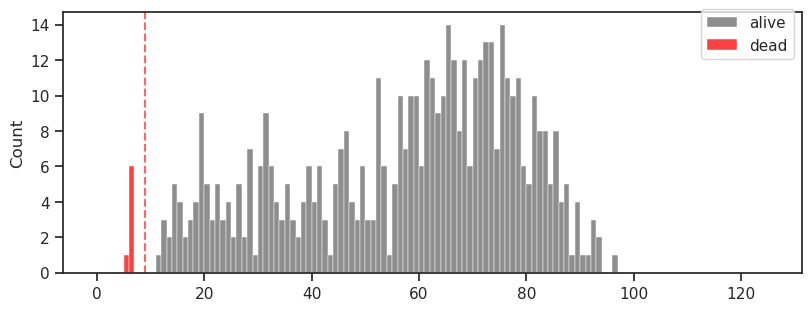

In [54]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 125, 126)
sns.histplot(loss['kl_diag'][~dead] * 1000, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 1000, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.legend()
move_legend(ax, (1., 1.04))
plt.show()

### Spike counts

In [55]:
lifetime, population, percents = sparse_score(data['z'][:, ~dead], cutoff=0.05)
print(percents)

{'0': 75.7, '1': 19.3, '2': 3.9, '3+': 1.1}

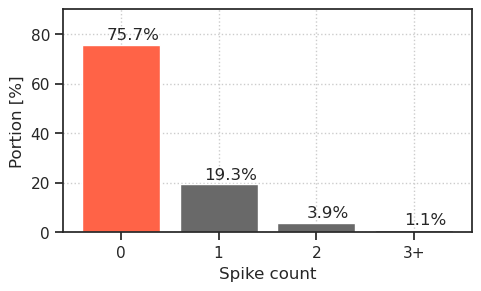

In [56]:
fig, ax = create_figure(1, 1, (4.7, 2.8))

max_val = float(list(percents.values())[0])
ax.set(
    xlabel='Spike count',
    ylabel='Portion [%]',
    ylim=(0, (np.ceil(max_val / 10) + 1) * 10),
)
colors = ['tomato' if lbl == '0' else 'dimgrey' for lbl in percents]
bars = ax.bar(percents.keys(), percents.values(), color=colors)

for bar in bars:
    y = bar.get_height()
    x = bar.get_x() + 1.3 * bar.get_width() / 2
    plt.text(x, y + 1, f'{y:0.1f}%', ha='center', va='bottom')

ax.locator_params(axis='y', nbins=5)

ax.grid()
plt.show()

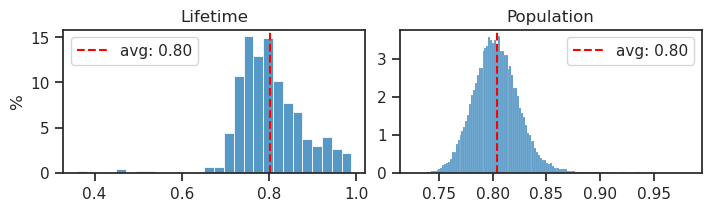

In [57]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(lifetime, stat='percent', ax=axes[0])
sns.histplot(population, stat='percent', ax=axes[1])

for i, x2p in enumerate([lifetime, population]):
    _a, _med = np.nanmean(x2p), np.nanmedian(x2p)
    # axes[i].axvline(_med, color='g', ls='--', label=f'median: {_med:0.2f}')
    axes[i].axvline(_a, color='r', ls='--', label=f'avg: {_a:0.2f}')

add_legend(axes)
axes[0].set(title='Lifetime', ylabel='%')
axes[1].set(title='Population', ylabel='')
plt.show()

In [58]:
tot_nspks = data['z'][:, ~dead].sum(1)
tot_firing = (data['z'][:, ~dead] > 0).mean(1)

min(tot_nspks), max(tot_nspks)

(86.0, 301.0)

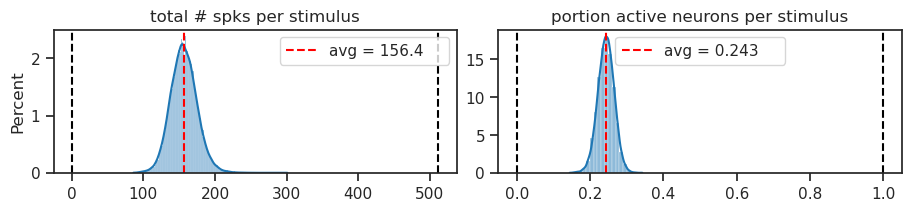

In [59]:
a = np.floor(min(tot_nspks) / 10) * 10
b = np.ceil(max(tot_nspks) / 10) * 10

fig, axes = create_figure(1, 2, (9, 2), layout='constrained')

sns.histplot(tot_nspks, bins=np.linspace(a, b, int(b - a) + 1), kde=True, stat='percent', ax=axes[0])
sns.histplot(tot_firing, bins=np.linspace(0, 1.0, 101), kde=True, stat='percent', ax=axes[1])

_a = tot_nspks.mean()
axes[0].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.1f}    ')
_a = tot_firing.mean()
axes[1].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.3f}    ')

axes[0].axvline(vae.cfg.n_latents, color='k', ls='--')
axes[1].axvline(1.0, color='k', ls='--')

axes[0].set_title('total # spks per stimulus')
axes[1].set(title='portion active neurons per stimulus', ylabel='')

for ax in axes.flat:
    ax.axvline(0, color='k', ls='--')
    ax.legend()
plt.show()

### Cosine sim enc/dec

In [60]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data

    w_dec = w_dec[:, ~dead]
    w_enc = w_enc[~dead]

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

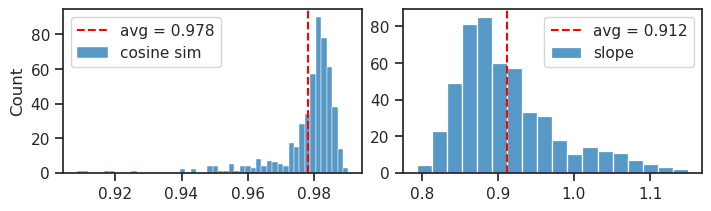

In [61]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(tonp(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(tonp(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')

for ax in axes.flat:
    ax.legend()
axes[1].set_ylabel('')
plt.show()

### Plot dec weights

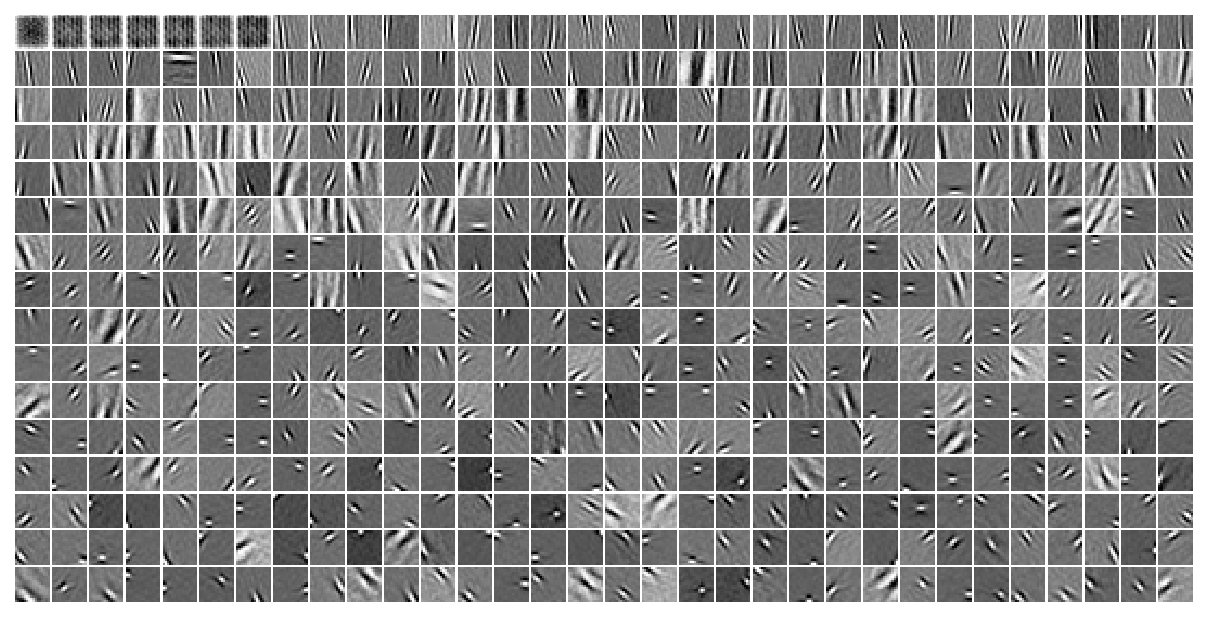

In [62]:
vae.show(dpi=150, order=np.argsort(loss['kl_diag']));

### Some more distributions

In [63]:
tr.model.temp, tr.cfg.kl_beta

(tensor(0.0500, device='cuda:0'), 1.0)

In [64]:
prior_rates = tonp(vae.log_rate)[:, ~dead].ravel()
rv = sp_stats.norm(*sp_stats.norm.fit(prior_rates))
xs = np.linspace(rv.ppf(1e-5), rv.ppf(1 - 1e-5), 1000)
pdf = rv.pdf(xs)

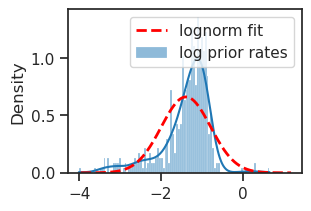

In [65]:
fig, ax = create_figure()

sns.histplot(prior_rates, stat='density', bins=100, kde=True, label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

In [66]:
ks = sp_stats.kstest(
    rvs=prior_rates,
    cdf=rv.cdf,
    alternative='two-sided',
)
print(ks)

KstestResult(statistic=0.15305070117302783, pvalue=8.549629926963597e-11, statistic_location=-1.4922553, 
statistic_sign=-1)

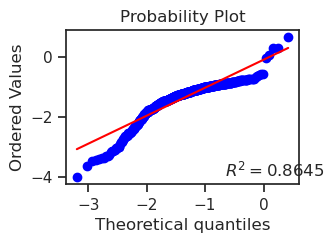

In [67]:
(osm, osr), (slope, intercept, r) = sp_stats.probplot(
    x=prior_rates,
    sparams=rv.args,
    rvalue=True,
    dist='norm',
    plot=plt,
)
plt.show()

In [68]:
posterior_log_rates = np.log(rates['r*dr'][:, ~dead]).ravel()
rv = sp_stats.norm(*sp_stats.norm.fit(posterior_log_rates))
xs = np.linspace(rv.ppf(1e-5), rv.ppf(1 - 1e-5), 1000)
pdf = rv.pdf(xs)

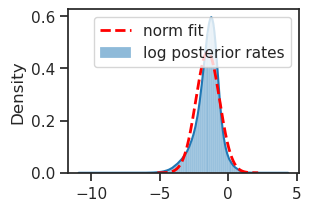

In [69]:
fig, ax = create_figure()

sns.histplot(posterior_log_rates, stat='density', bins=100, kde=True, label='log posterior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='norm fit')
add_legend(ax)
plt.show()

In [70]:
ks = sp_stats.kstest(
    rvs=posterior_log_rates,
    cdf=rv.cdf,
    alternative='two-sided',
)
print(ks)

KstestResult(statistic=0.06696042059181717, pvalue=0.0, statistic_location=-1.6898683, statistic_sign=-1)

In [71]:
vae.log_rate.squeeze()[dead]

tensor([-6.0204,  3.6681,  3.8504,  3.6630,  3.7653,  3.7019,  3.8593],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [72]:
loss['kl_diag'][dead]

array([0.0050492 , 0.0061526 , 0.00633151, 0.00616054, 0.00624737,
       0.00625545, 0.0062989 ], dtype=float32)

In [73]:
from fitter import Fitter
f = Fitter(np.exp(prior_rates), distributions=['lognorm', 'loggamma'])
f.fit()

2024-05-08 20:34:35.506 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=15.600896)
2024-05-08 20:34:35.543 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted loggamma distribution with error=19.768535)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,15.600896,1209.995625,1222.669300,inf,0.078778,3.576434e-03
loggamma,19.768535,2375.377225,2388.050901,inf,0.142055,2.354494e-09


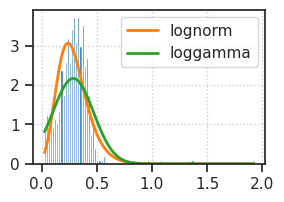

In [74]:
f.summary()

## Loggabor

In [6]:
from analysis.loggabor import fit_loggabor
from figures.theta import plot_theta
from figures.imgs import plot_weights

### Load model

In [3]:
tr, meta = load_model(
    'poisson_uniform_c(-4)_DOVES_z-512_fp_<lin|lin>',
    'mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_05_08,19:25)',
    device=device,
)
data, loss, etc = tr.validate()

In [5]:
dead_thres = 0.009
dead = np.logical_or(
    loss['kl_diag'] < dead_thres,
    tonp(tr.model.log_rate.squeeze()) > 1.0,
)
dead.sum()

7

### Fit loggabor

In [7]:
results = fit_loggabor(tr, verbose=True)

 28%|███        | 144/512 [00:05<00:09, 37.16it/s]

100%|███████████| 512/512 [00:18<00:00, 28.27it/s]


512

(512, 9)

In [9]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,kl,prior_rates
count,504.000000,504.000000,504.000000,502.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,7.492145,7.429447,0.073277,0.286797,-0.122732,0.469967,0.386831,92.769891,0.057697,0.289638
std,3.900592,4.224704,1.024522,0.378427,1.266724,0.657871,0.452026,47.304614,0.020936,0.157789
min,0.406083,0.284160,-1.570796,0.088224,-4.146423,0.041057,0.057484,0.024325,0.011846,0.018099
25%,4.179494,3.575165,-0.914593,0.227348,-0.827516,0.338604,0.197829,59.096452,0.041740,0.209366
50%,7.786039,7.535076,0.004177,0.254550,-0.128881,0.412729,0.300554,90.000000,0.062420,0.291820
75%,10.737862,11.067054,1.042146,0.289152,0.572390,0.491432,0.508562,125.875183,0.073860,0.366153
max,14.508743,15.677455,1.570796,7.708300,6.450661,12.874421,8.976002,179.968793,0.096638,1.933243


In [10]:
try:
    key = results.columns[-1] if tr.model.cfg.fit_prior else 'kl'
    rates_axial = results.loc[(results['label'] == 'axial') & ~dead, key].values
    rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, key].values
    print(f"{sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')}")
    a, b = len(rates_axial), len(rates_oblique)
    print(f"portions:   axial = {a/(a+b):0.2f} —— vs. —— oblique = {b/(a+b):0.2f}")
except KeyError:
    pass

MannwhitneyuResult(statistic=17622.0, pvalue=1.739950485298207e-16)

portions:   axial = 0.58 —— vs. —— oblique = 0.42

In [11]:
from figures.theta import plot_theta

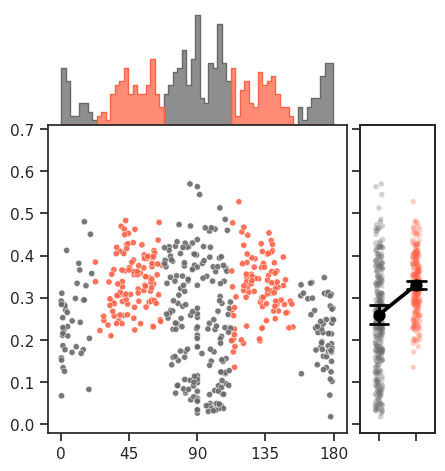

In [38]:
plot_theta(results);

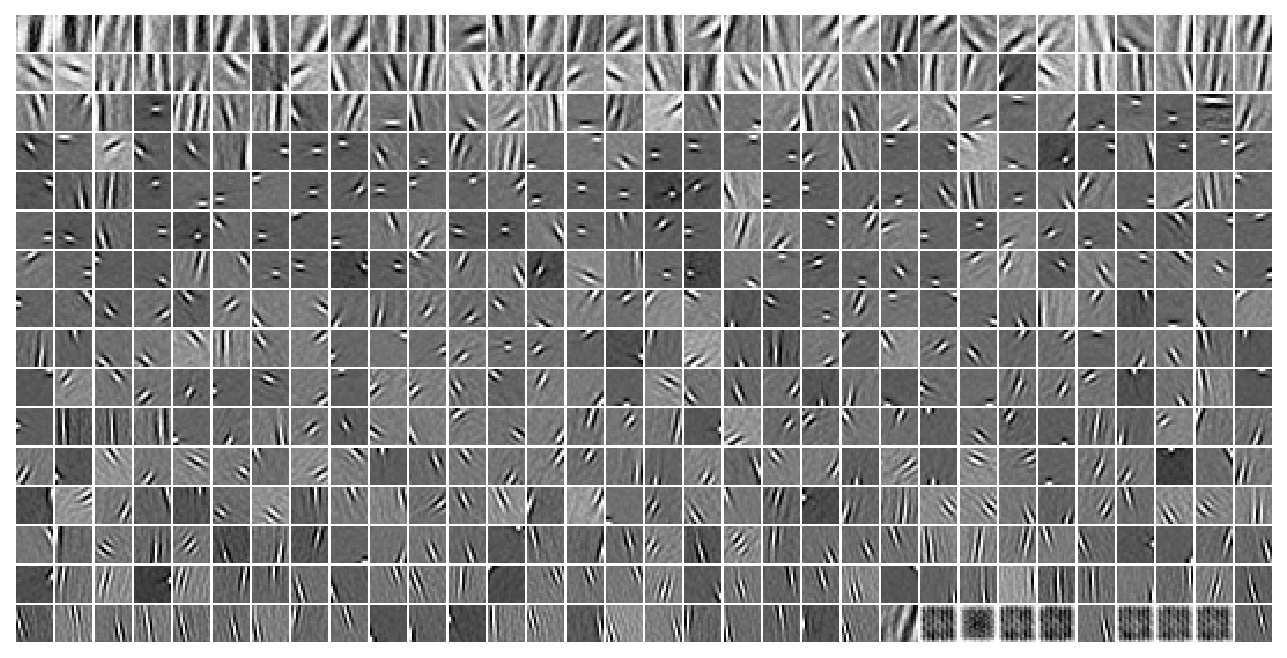

In [39]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show(order=order)

In [40]:
w_dec = tonp(tr.model.fc_dec.weight.data)
w_dec = w_dec.T.reshape(-1, 16, 16)
ids = np.argsort(results['sf_0'].values)

In [47]:
results['sf_0'][ids[:32]].values, results['sf_0'][ids[-32:]].values

(array([0.08822445, 0.0947685 , 0.09488058, 0.1061843 , 0.1091126 ,
        0.10978762, 0.11591194, 0.11717982, 0.11883332, 0.12056988,
        0.12604092, 0.12786134, 0.12917943, 0.12967356, 0.13065386,
        0.13362543, 0.13581613, 0.13596838, 0.13651024, 0.13661417,
        0.13772229, 0.13840516, 0.13851567, 0.13967077, 0.14195262,
        0.14484594, 0.15003537, 0.15295975, 0.1532612 , 0.15413218,
        0.15453835, 0.15456359]),
 array([0.40403321, 0.40404965, 0.40749353, 0.41603848, 0.42343088,
        0.42482276, 0.42846629, 0.42942353, 0.44032169, 0.45676328,
        0.458535  , 0.48675371, 0.50179077, 0.52541479, 0.54519126,
        0.55759453, 0.70912906, 0.83864438, 0.91712643, 2.13903302,
        3.3904252 , 7.7083003 ,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan]))

In [48]:
results['sf_0'][ids[-42:-10]].values

array([0.39791495, 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.40114323, 0.4020769 ,
       0.40403321, 0.40404965, 0.40749353, 0.41603848, 0.42343088,
       0.42482276, 0.42846629, 0.42942353, 0.44032169, 0.45676328,
       0.458535  , 0.48675371, 0.50179077, 0.52541479, 0.54519126,
       0.55759453, 0.70912906, 0.83864438, 0.91712643, 2.13903302,
       3.3904252 , 7.7083003 ])

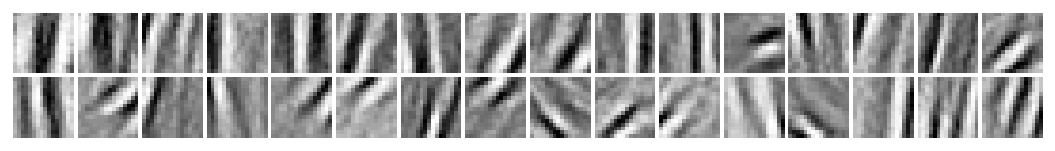

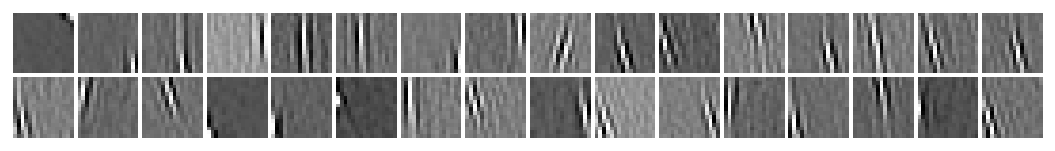

In [49]:
plot_weights(w_dec[ids[:32]], nrows=2, dpi=130)
plt.show()

plot_weights(w_dec[ids[-42:-10]], nrows=2, dpi=130)
plt.show()